In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle
import gc
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from tqdm.auto import tqdm
import math

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve
)
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
class Config:
    # Input Paths
    DENSENET_FEAT = '/kaggle/input/feature-2d-ct-brain-stroke/pytorch/default/1/features_densenet.pkl'
    VIT_FEAT      = '/kaggle/input/feature-2d-ct-brain-stroke/pytorch/default/1/features_vit.pkl'
    SWIN_FEAT     = '/kaggle/input/feature-2d-ct-brain-stroke/pytorch/default/2/features_swin.pkl'
    METADATA_PATH = '/kaggle/input/study-metadata/study_metadata.pkl'
    
    # Dimensions
    DIM_DENSE = 1024
    DIM_VIT   = 768
    DIM_SWIN  = 768
    
    # Model Architecture
    PROJ_DIM    = 512
    MODEL_DIM   = 1024
    NUM_HEADS   = 8
    NUM_LAYERS  = 2
    DROPOUT     = 0.3
    
    # Training
    MAX_SEQ_LEN = 60
    BATCH_SIZE  = 32
    NUM_EPOCHS  = 30
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY  = 1e-4
    
    # Misc
    SEED = 42
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = Config()
print(f"Running on {cfg.DEVICE}")

Running on cuda


In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(cfg.SEED)

In [4]:
def load_and_merge_features():
    print(f"{'='*40}\nLOADING & MERGING FEATURES\n{'='*40}")
    
    # 1. Load Metadata
    print("Loading Metadata...")
    with open(cfg.METADATA_PATH, 'rb') as f:
        meta = pickle.load(f)
    study_to_slices = meta['study_to_slices']
    
    study_labels = {}
    for sid, slices in study_to_slices.items():
        sorted_slices = sorted(slices, key=lambda x: x['z_pos'])
        labels = [s['label'] for s in sorted_slices]
        study_labels[sid] = np.array(labels, dtype=np.float32)
        
    print(f"✓ Metadata loaded: {len(study_labels)} studies")
    
    # 2. Load Features
    print(f"\nLoading DenseNet Features...")
    with open(cfg.DENSENET_FEAT, 'rb') as f:
        feats_dense = pickle.load(f)
    print(f"✓ DenseNet Loaded. Count: {len(feats_dense)}")
    
    print(f"\nLoading ViT Features...")
    with open(cfg.VIT_FEAT, 'rb') as f:
        feats_vit = pickle.load(f)
    print(f"✓ ViT Loaded. Count: {len(feats_vit)}")
    
    print(f"\nLoading Swin Features...")
    with open(cfg.SWIN_FEAT, 'rb') as f:
        feats_swin = pickle.load(f)
    print(f"✓ Swin Loaded. Count: {len(feats_swin)}")
    
    # 3. Merging
    common_ids = set(feats_dense.keys()) & set(feats_vit.keys()) & set(feats_swin.keys()) & set(study_labels.keys())
    print(f"\nMerging features for {len(common_ids)} common studies...")
    
    merged_data = []
    
    for sid in tqdm(common_ids, desc="Merging"):
        f1 = feats_dense[sid]
        f2 = feats_vit[sid]
        f3 = feats_swin[sid]
        lbl = study_labels[sid]
        
        min_len = min(len(f1), len(f2), len(f3), len(lbl))
        
        # Check for NaN/Inf in features
        concat_feat = np.concatenate([
            f1[:min_len], 
            f2[:min_len], 
            f3[:min_len]
        ], axis=1)
        
        # Replace NaN/Inf with 0
        concat_feat = np.nan_to_num(concat_feat, nan=0.0, posinf=0.0, neginf=0.0)
        
        merged_data.append({
            'study_id': sid,
            'features': concat_feat.astype(np.float32),
            'labels': lbl[:min_len].astype(np.float32),
            'study_label': max(lbl)
        })
        
    del feats_dense, feats_vit, feats_swin, study_to_slices
    gc.collect()
    
    return pd.DataFrame(merged_data)

df_all = load_and_merge_features()
print(f"✓ Final Data Shape: {len(df_all)} studies")

LOADING & MERGING FEATURES
Loading Metadata...
✓ Metadata loaded: 21744 studies

Loading DenseNet Features...
✓ DenseNet Loaded. Count: 21744

Loading ViT Features...
✓ ViT Loaded. Count: 21744

Loading Swin Features...
✓ Swin Loaded. Count: 21744

Merging features for 21744 common studies...


Merging:   0%|          | 0/21744 [00:00<?, ?it/s]

✓ Final Data Shape: 21744 studies


In [5]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=cfg.SEED)
train_idx, temp_idx = next(splitter.split(df_all, df_all['study_label']))
temp_df = df_all.iloc[temp_idx].reset_index(drop=True)

val_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=cfg.SEED)
val_idx, test_idx = next(val_splitter.split(temp_df, temp_df['study_label']))

train_df = df_all.iloc[train_idx].reset_index(drop=True)
val_df = temp_df.iloc[val_idx].reset_index(drop=True)
test_df = temp_df.iloc[test_idx].reset_index(drop=True)

print(f"Train Studies: {len(train_df)}")
print(f"Val Studies  : {len(val_df)}")
print(f"Test Studies : {len(test_df)}")

Train Studies: 15220
Val Studies  : 3262
Test Studies : 3262


In [6]:
# ============================================================
# DATASET & DATALOADER
# ============================================================
class SequenceDataset(Dataset):
    def __init__(self, df):
        self.data = df.to_dict('records')
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'features': item['features'],
            'labels': item['labels']
        }

def collate_fn(batch):
    max_len = cfg.MAX_SEQ_LEN
    feat_dim = batch[0]['features'].shape[1]
    batch_size = len(batch)
    
    padded_feats = torch.zeros(batch_size, max_len, feat_dim)
    padded_labels = torch.zeros(batch_size, max_len)
    attention_mask = torch.zeros(batch_size, max_len)
    loss_mask = torch.zeros(batch_size, max_len)
    
    for i, item in enumerate(batch):
        seq_len = min(len(item['features']), max_len)
        
        f = torch.from_numpy(item['features'][:seq_len])
        l = torch.from_numpy(item['labels'][:seq_len])
        
        padded_feats[i, :seq_len, :] = f
        padded_labels[i, :seq_len] = l
        loss_mask[i, :seq_len] = 1.0
        attention_mask[i, seq_len:] = 1.0
        
    return {
        'features': padded_feats,
        'labels': padded_labels,
        'loss_mask': loss_mask,
        'padding_mask': attention_mask.bool()
    }

train_loader = DataLoader(SequenceDataset(train_df), batch_size=cfg.BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(SequenceDataset(val_df), batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(SequenceDataset(test_df), batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("✓ DataLoaders ready.")

✓ DataLoaders ready.


In [7]:
# ============================================================
# MODEL
# ============================================================
class FusionTransformer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
        # Projection Heads with Batch Normalization
        self.proj_dense = nn.Sequential(
            nn.Linear(cfg.DIM_DENSE, cfg.PROJ_DIM),
            nn.BatchNorm1d(cfg.PROJ_DIM),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.proj_vit = nn.Sequential(
            nn.Linear(cfg.DIM_VIT, cfg.PROJ_DIM),
            nn.BatchNorm1d(cfg.PROJ_DIM),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.proj_swin = nn.Sequential(
            nn.Linear(cfg.DIM_SWIN, cfg.PROJ_DIM),
            nn.BatchNorm1d(cfg.PROJ_DIM),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Fusion Layer
        self.fusion = nn.Sequential(
            nn.Linear(cfg.PROJ_DIM * 3, cfg.MODEL_DIM),
            nn.LayerNorm(cfg.MODEL_DIM),
            nn.ReLU()
        )
        
        # Positional Encoding
        self.pos_encoder = nn.Parameter(torch.randn(1, cfg.MAX_SEQ_LEN, cfg.MODEL_DIM) * 0.02)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=cfg.MODEL_DIM,
            nhead=cfg.NUM_HEADS,
            dim_feedforward=2048,
            dropout=cfg.DROPOUT,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=cfg.NUM_LAYERS)
        
        # Output Head
        self.classifier = nn.Linear(cfg.MODEL_DIM, 1)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        
    def forward(self, x, src_key_padding_mask=None):
        # x shape: (B, L, 2560)
        B, L, _ = x.shape
        
        # Split Features
        f_dense = x[:, :, :cfg.DIM_DENSE]
        f_vit   = x[:, :, cfg.DIM_DENSE : cfg.DIM_DENSE + cfg.DIM_VIT]
        f_swin  = x[:, :, cfg.DIM_DENSE + cfg.DIM_VIT :]
        
        # Project (reshape for BatchNorm1d)
        p_dense = self.proj_dense(f_dense.reshape(B*L, -1)).reshape(B, L, -1)
        p_vit   = self.proj_vit(f_vit.reshape(B*L, -1)).reshape(B, L, -1)
        p_swin  = self.proj_swin(f_swin.reshape(B*L, -1)).reshape(B, L, -1)
        
        # Concatenate & Fuse
        concat = torch.cat([p_dense, p_vit, p_swin], dim=2)
        x = self.fusion(concat)
        
        # Add Positional Encoding
        seq_len = x.size(1)
        x = x + self.pos_encoder[:, :seq_len, :]
        
        # Transformer
        x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)
        
        # Classification
        logits = self.classifier(x)
        
        return logits

model = FusionTransformer(cfg).to(cfg.DEVICE)
print(f"✓ Model Initialized. Trainable Params: {sum(p.numel() for p in model.parameters()):,}")

✓ Model Initialized. Trainable Params: 19,753,473


In [8]:
criterion = nn.BCEWithLogitsLoss(reduction='none')
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=cfg.WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.NUM_EPOCHS)

In [9]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    
    for batch in tqdm(loader, desc="Train", leave=False):
        feats = batch['features'].to(cfg.DEVICE)
        labels = batch['labels'].to(cfg.DEVICE).unsqueeze(-1)
        loss_mask = batch['loss_mask'].to(cfg.DEVICE).unsqueeze(-1)
        padding_mask = batch['padding_mask'].to(cfg.DEVICE)
        
        optimizer.zero_grad()
        
        # Forward
        outputs = model(feats, src_key_padding_mask=padding_mask)
        
        # Calculate Loss
        raw_loss = criterion(outputs, labels)
        masked_loss = (raw_loss * loss_mask).sum() / (loss_mask.sum() + 1e-8)
        
        # Check for NaN
        if torch.isnan(masked_loss):
            print("Warning: NaN loss detected, skipping batch")
            continue
        
        masked_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += masked_loss.item()
        
    return total_loss / len(loader)

In [10]:
def validate(model, loader, return_detailed=False):
    """
    Validate model with comprehensive metrics
    
    Args:
        model: PyTorch model
        loader: DataLoader
        return_detailed: If True, return detailed predictions and labels
    
    Returns:
        If return_detailed=False: (loss, auc, acc, precision, recall, f1)
        If return_detailed=True: (loss, metrics_dict, all_preds, all_labels)
    """
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Val", leave=False):
            feats = batch['features'].to(cfg.DEVICE)
            labels = batch['labels'].to(cfg.DEVICE).unsqueeze(-1)
            loss_mask = batch['loss_mask'].to(cfg.DEVICE).unsqueeze(-1)
            padding_mask = batch['padding_mask'].to(cfg.DEVICE)
            
            outputs = model(feats, src_key_padding_mask=padding_mask)
            
            # Loss
            raw_loss = criterion(outputs, labels)
            masked_loss = (raw_loss * loss_mask).sum() / (loss_mask.sum() + 1e-8)
            total_loss += masked_loss.item()
            
            # Extract valid predictions
            valid_mask = loss_mask.bool().flatten()
            
            batch_preds = torch.sigmoid(outputs).flatten()[valid_mask]
            batch_labels = labels.flatten()[valid_mask]
            
            # Check for NaN
            if not torch.isnan(batch_preds).any():
                all_preds.extend(batch_preds.cpu().numpy())
                all_labels.extend(batch_labels.cpu().numpy())
    
    # Convert to numpy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_preds_binary = (all_preds > 0.5).astype(int)
    
    # Handle NaN
    if len(all_preds) == 0 or np.isnan(all_preds).any():
        print("⚠️ Warning: NaN detected in predictions")
        if return_detailed:
            return total_loss / len(loader), {}, all_preds, all_labels
        return total_loss / len(loader), 0.5, 0.5, 0.5, 0.5, 0.5
    
    # Calculate metrics
    avg_loss = total_loss / len(loader)
    auc = roc_auc_score(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds_binary)
    precision = precision_score(all_labels, all_preds_binary, zero_division=0)
    recall = recall_score(all_labels, all_preds_binary, zero_division=0)
    f1 = f1_score(all_labels, all_preds_binary, zero_division=0)
    
    if return_detailed:
        metrics_dict = {
            'loss': avg_loss,
            'auc': auc,
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
        return avg_loss, metrics_dict, all_preds, all_labels
    
    return avg_loss, auc, acc, precision, recall, f1

In [11]:
history = {
    'train_loss': [],
    'val_loss': [],
    'val_auc': [],
    'val_accuracy': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': [],
    'learning_rate': []
}

best_auc = 0
best_epoch = 0

print(f"\n{'='*60}")
print(f"STARTING SEQUENCE TRAINING ({cfg.NUM_EPOCHS} Epochs)")
print(f"{'='*60}\n")

for epoch in range(cfg.NUM_EPOCHS):
    # Training
    t_loss = train_epoch(model, train_loader)
    
    # Validation
    v_loss, v_auc, v_acc, v_precision, v_recall, v_f1 = validate(model, val_loader)
    
    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['val_auc'].append(v_auc)
    history['val_accuracy'].append(v_acc)
    history['val_precision'].append(v_precision)
    history['val_recall'].append(v_recall)
    history['val_f1'].append(v_f1)
    history['learning_rate'].append(current_lr)
    
    # Print metrics
    print(f"Epoch {epoch+1:02d}/{cfg.NUM_EPOCHS}")
    print(f"  Train Loss: {t_loss:.4f}")
    print(f"  Val Loss  : {v_loss:.4f}")
    print(f"  Val AUC   : {v_auc:.4f} | Acc: {v_acc:.4f} | F1: {v_f1:.4f}")
    print(f"  Precision : {v_precision:.4f} | Recall: {v_recall:.4f}")
    print(f"  LR        : {current_lr:.6f}")
    
    # Save best model
    if v_auc > best_auc:
        best_auc = v_auc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_auc': best_auc,
            'history': history
        }, "fusion_transformer_best.pth")
        print(f"  🔥 New Best Model Saved! (AUC: {best_auc:.4f})")
    
    print("-" * 60)

print(f"\n{'='*60}")
print(f"TRAINING FINISHED")
print(f"{'='*60}")
print(f"Best AUC: {best_auc:.4f} at Epoch {best_epoch}")


STARTING SEQUENCE TRAINING (30 Epochs)



Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 01/30
  Train Loss: 0.1117
  Val Loss  : 0.1053
  Val AUC   : 0.9882 | Acc: 0.9621 | F1: 0.8703
  Precision : 0.8434 | Recall: 0.8990
  LR        : 0.000100
  🔥 New Best Model Saved! (AUC: 0.9882)
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 02/30
  Train Loss: 0.0961
  Val Loss  : 0.0959
  Val AUC   : 0.9886 | Acc: 0.9630 | F1: 0.8727
  Precision : 0.8491 | Recall: 0.8976
  LR        : 0.000099
  🔥 New Best Model Saved! (AUC: 0.9886)
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 03/30
  Train Loss: 0.0939
  Val Loss  : 0.0926
  Val AUC   : 0.9888 | Acc: 0.9651 | F1: 0.8746
  Precision : 0.8880 | Recall: 0.8616
  LR        : 0.000098
  🔥 New Best Model Saved! (AUC: 0.9888)
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 04/30
  Train Loss: 0.0934
  Val Loss  : 0.0992
  Val AUC   : 0.9889 | Acc: 0.9615 | F1: 0.8702
  Precision : 0.8307 | Recall: 0.9137
  LR        : 0.000096
  🔥 New Best Model Saved! (AUC: 0.9889)
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 05/30
  Train Loss: 0.0915
  Val Loss  : 0.0948
  Val AUC   : 0.9888 | Acc: 0.9648 | F1: 0.8704
  Precision : 0.9082 | Recall: 0.8356
  LR        : 0.000093
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 06/30
  Train Loss: 0.0902
  Val Loss  : 0.0936
  Val AUC   : 0.9888 | Acc: 0.9647 | F1: 0.8715
  Precision : 0.8968 | Recall: 0.8476
  LR        : 0.000090
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 07/30
  Train Loss: 0.0895
  Val Loss  : 0.0964
  Val AUC   : 0.9890 | Acc: 0.9655 | F1: 0.8772
  Precision : 0.8829 | Recall: 0.8715
  LR        : 0.000087
  🔥 New Best Model Saved! (AUC: 0.9890)
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 08/30
  Train Loss: 0.0883
  Val Loss  : 0.0902
  Val AUC   : 0.9891 | Acc: 0.9654 | F1: 0.8771
  Precision : 0.8823 | Recall: 0.8720
  LR        : 0.000083
  🔥 New Best Model Saved! (AUC: 0.9891)
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 09/30
  Train Loss: 0.0880
  Val Loss  : 0.0935
  Val AUC   : 0.9892 | Acc: 0.9656 | F1: 0.8772
  Precision : 0.8845 | Recall: 0.8701
  LR        : 0.000079
  🔥 New Best Model Saved! (AUC: 0.9892)
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 10/30
  Train Loss: 0.0858
  Val Loss  : 0.0914
  Val AUC   : 0.9891 | Acc: 0.9647 | F1: 0.8775
  Precision : 0.8613 | Recall: 0.8944
  LR        : 0.000075
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 11/30
  Train Loss: 0.0846
  Val Loss  : 0.0943
  Val AUC   : 0.9891 | Acc: 0.9655 | F1: 0.8764
  Precision : 0.8895 | Recall: 0.8638
  LR        : 0.000070
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 12/30
  Train Loss: 0.0831
  Val Loss  : 0.0964
  Val AUC   : 0.9893 | Acc: 0.9650 | F1: 0.8783
  Precision : 0.8648 | Recall: 0.8921
  LR        : 0.000065
  🔥 New Best Model Saved! (AUC: 0.9893)
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 13/30
  Train Loss: 0.0815
  Val Loss  : 0.0940
  Val AUC   : 0.9889 | Acc: 0.9643 | F1: 0.8752
  Precision : 0.8645 | Recall: 0.8862
  LR        : 0.000060
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 14/30
  Train Loss: 0.0799
  Val Loss  : 0.0900
  Val AUC   : 0.9893 | Acc: 0.9660 | F1: 0.8782
  Precision : 0.8910 | Recall: 0.8658
  LR        : 0.000055
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 15/30
  Train Loss: 0.0782
  Val Loss  : 0.1042
  Val AUC   : 0.9892 | Acc: 0.9654 | F1: 0.8713
  Precision : 0.9199 | Recall: 0.8276
  LR        : 0.000050
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 16/30
  Train Loss: 0.0758
  Val Loss  : 0.0970
  Val AUC   : 0.9892 | Acc: 0.9653 | F1: 0.8784
  Precision : 0.8703 | Recall: 0.8866
  LR        : 0.000045
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 17/30
  Train Loss: 0.0745
  Val Loss  : 0.0979
  Val AUC   : 0.9890 | Acc: 0.9648 | F1: 0.8776
  Precision : 0.8643 | Recall: 0.8914
  LR        : 0.000040
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 18/30
  Train Loss: 0.0717
  Val Loss  : 0.0995
  Val AUC   : 0.9891 | Acc: 0.9654 | F1: 0.8717
  Precision : 0.9164 | Recall: 0.8312
  LR        : 0.000035
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 19/30
  Train Loss: 0.0697
  Val Loss  : 0.0961
  Val AUC   : 0.9886 | Acc: 0.9650 | F1: 0.8733
  Precision : 0.8943 | Recall: 0.8532
  LR        : 0.000030
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 20/30
  Train Loss: 0.0679
  Val Loss  : 0.1015
  Val AUC   : 0.9886 | Acc: 0.9643 | F1: 0.8735
  Precision : 0.8746 | Recall: 0.8724
  LR        : 0.000025
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 21/30
  Train Loss: 0.0653
  Val Loss  : 0.0978
  Val AUC   : 0.9886 | Acc: 0.9648 | F1: 0.8740
  Precision : 0.8853 | Recall: 0.8631
  LR        : 0.000021
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 22/30
  Train Loss: 0.0639
  Val Loss  : 0.1037
  Val AUC   : 0.9884 | Acc: 0.9645 | F1: 0.8752
  Precision : 0.8693 | Recall: 0.8811
  LR        : 0.000017
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 23/30
  Train Loss: 0.0623
  Val Loss  : 0.1098
  Val AUC   : 0.9884 | Acc: 0.9629 | F1: 0.8724
  Precision : 0.8493 | Recall: 0.8968
  LR        : 0.000013
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 24/30
  Train Loss: 0.0609
  Val Loss  : 0.1133
  Val AUC   : 0.9882 | Acc: 0.9649 | F1: 0.8727
  Precision : 0.8956 | Recall: 0.8510
  LR        : 0.000010
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 25/30
  Train Loss: 0.0598
  Val Loss  : 0.1129
  Val AUC   : 0.9878 | Acc: 0.9636 | F1: 0.8722
  Precision : 0.8665 | Recall: 0.8779
  LR        : 0.000007
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 26/30
  Train Loss: 0.0585
  Val Loss  : 0.1166
  Val AUC   : 0.9881 | Acc: 0.9647 | F1: 0.8749
  Precision : 0.8765 | Recall: 0.8734
  LR        : 0.000004
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 27/30
  Train Loss: 0.0574
  Val Loss  : 0.1196
  Val AUC   : 0.9879 | Acc: 0.9642 | F1: 0.8732
  Precision : 0.8745 | Recall: 0.8718
  LR        : 0.000002
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 28/30
  Train Loss: 0.0568
  Val Loss  : 0.1164
  Val AUC   : 0.9876 | Acc: 0.9639 | F1: 0.8715
  Precision : 0.8774 | Recall: 0.8656
  LR        : 0.000001
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 29/30
  Train Loss: 0.0563
  Val Loss  : 0.1182
  Val AUC   : 0.9876 | Acc: 0.9638 | F1: 0.8716
  Precision : 0.8754 | Recall: 0.8678
  LR        : 0.000000
------------------------------------------------------------


Train:   0%|          | 0/476 [00:00<?, ?it/s]

Val:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 30/30
  Train Loss: 0.0562
  Val Loss  : 0.1180
  Val AUC   : 0.9876 | Acc: 0.9638 | F1: 0.8715
  Precision : 0.8761 | Recall: 0.8669
  LR        : 0.000000
------------------------------------------------------------

TRAINING FINISHED
Best AUC: 0.9893 at Epoch 12


In [12]:
def plot_training_history(history):
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.color': '#cccccc',
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10
    })

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    # fig.suptitle('Training Metrics over Epochs', fontsize=16, y=0.95)
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Define clean colors
    col_train = '#1f77b4' # Blue
    col_val   = '#ff7f0e' # Orange
    col_acc   = '#2ca02c' # Green
    col_lr    = '#9467bd' # Purple
    
    # 1. Loss
    ax = axes[0, 0]
    ax.plot(epochs, history['train_loss'], label='Train Loss', color=col_train, marker='o', markersize=4)
    ax.plot(epochs, history['val_loss'], label='Val Loss', color=col_val, marker='s', markersize=4)
    ax.set_title('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    # 2. AUC
    ax = axes[0, 1]
    ax.plot(epochs, history['val_auc'], label='Val AUC', color=col_train, marker='o', markersize=4)
    best_auc = max(history['val_auc'])
    ax.axhline(y=best_auc, color='gray', linestyle='--', alpha=0.5, label=f'Best: {best_auc:.4f}')
    ax.set_title('AUC Score')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUC')
    ax.legend()

    # 3. Accuracy
    ax = axes[0, 2]
    ax.plot(epochs, history['val_accuracy'], label='Val Accuracy', color=col_acc, marker='o', markersize=4)
    ax.set_title('Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()

    # 4. Precision & Recall
    ax = axes[1, 0]
    ax.plot(epochs, history['val_precision'], label='Precision', color='#d62728', marker='^', markersize=4) # Red
    ax.plot(epochs, history['val_recall'], label='Recall', color='#17becf', marker='v', markersize=4) # Cyan
    ax.set_title('Precision & Recall')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.legend()

    # 5. F1 Score
    ax = axes[1, 1]
    ax.plot(epochs, history['val_f1'], label='F1 Score', color='#8c564b', marker='D', markersize=4) # Brown
    ax.set_title('F1 Score')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.legend()

    # 6. Learning Rate
    ax = axes[1, 2]
    ax.plot(epochs, history['learning_rate'], label='LR', color=col_lr, linestyle='--')
    ax.set_title('Learning Rate')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('LR')
    ax.set_yscale('log')
    ax.legend()

    plt.tight_layout()
    plt.savefig('training_history_clean.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Clean plot saved as 'training_history_clean.png'")


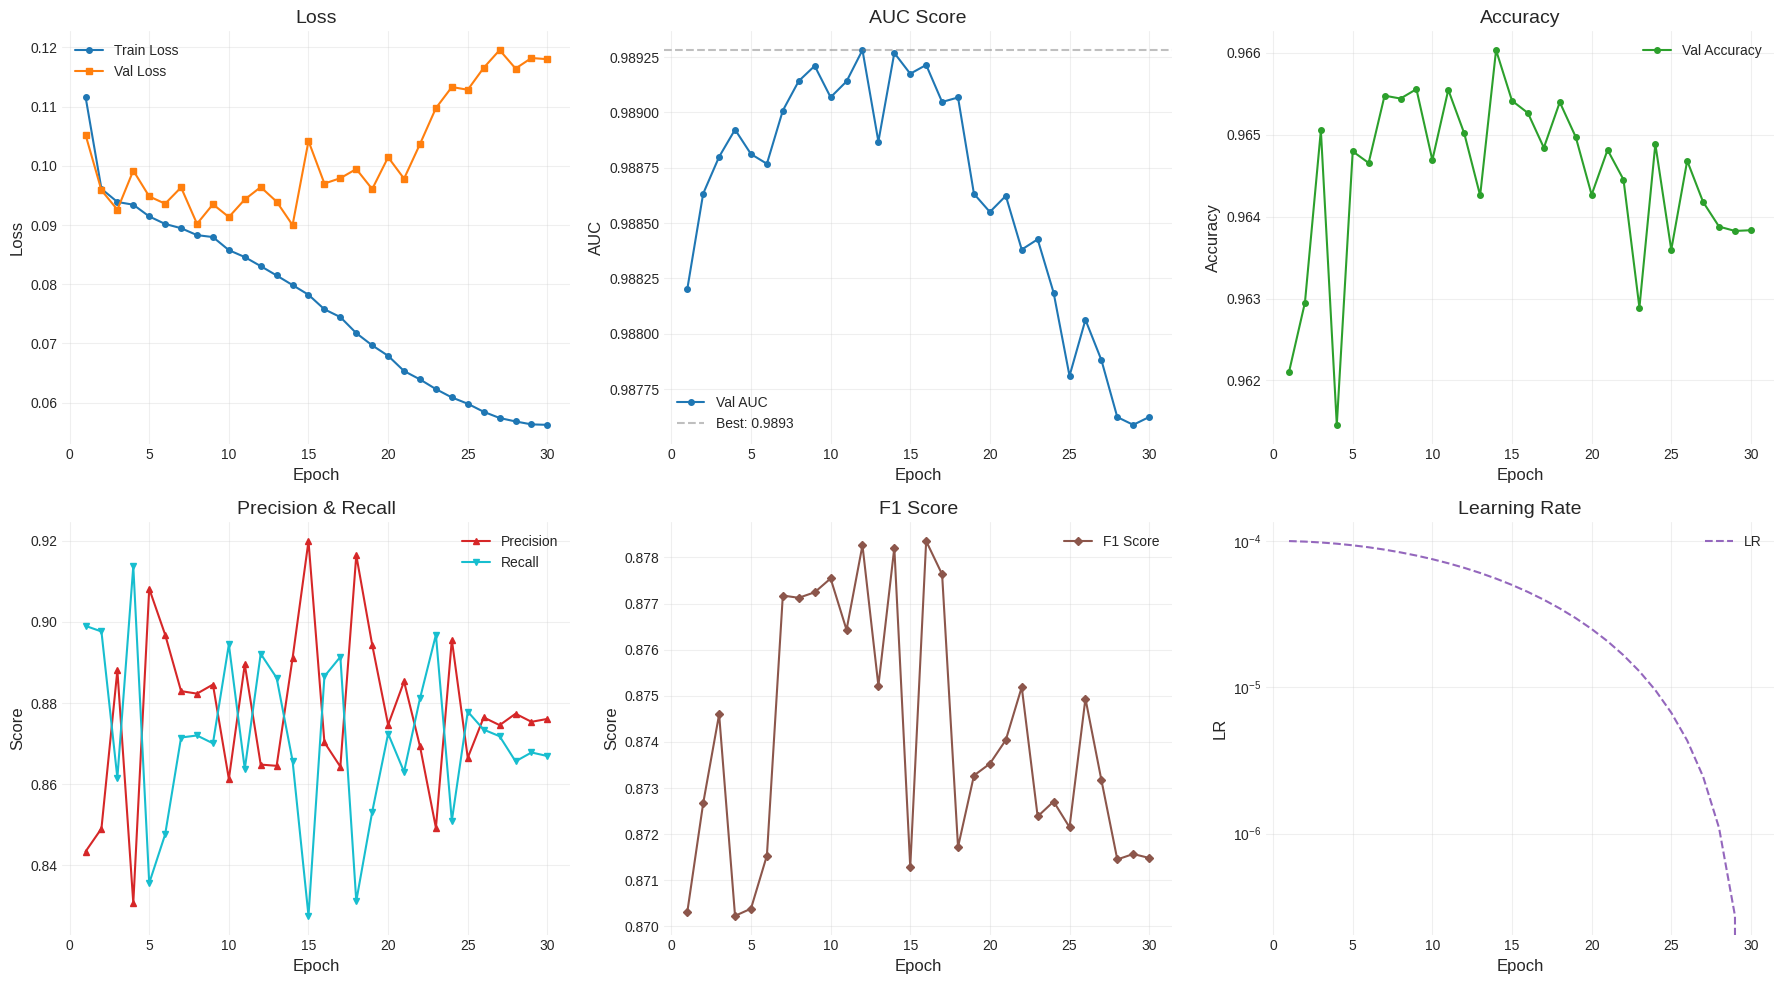

✓ Clean plot saved as 'training_history_clean.png'


In [13]:
plot_training_history(history)


In [14]:
def plot_test_evaluation(y_true, y_pred_proba, y_pred_binary):
    # Set clean style manually
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.color': '#cccccc',
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12
    })
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.25)
    
    # Define colors
    col_pos = '#1f77b4' # Blue
    col_neg = '#ff7f0e' # Orange
    col_line = '#333333' # Dark Grey
    
    # 1. Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(y_true, y_pred_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
                cbar=False, square=True, annot_kws={"size": 12, "weight": "bold"})
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    ax1.set_title('Confusion Matrix')
    ax1.set_xticklabels(['Neg', 'Pos'])
    ax1.set_yticklabels(['Neg', 'Pos'])
    
    # 2. Normalized Confusion Matrix
    ax2 = fig.add_subplot(gs[0, 1])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Greys', ax=ax2,
                cbar=False, square=True, annot_kws={"size": 12})
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')
    ax2.set_title('Normalized CM')
    ax2.set_xticklabels(['Neg', 'Pos'])
    ax2.set_yticklabels(['Neg', 'Pos'])
    
    # 3. ROC Curve
    ax3 = fig.add_subplot(gs[0, 2])
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    ax3.plot(fpr, tpr, linewidth=2, color=col_pos, label=f'AUC = {auc_score:.4f}')
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve')
    ax3.legend(loc='lower right')
    
    # 4. Precision-Recall Curve
    ax4 = fig.add_subplot(gs[1, 0])
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
    ax4.plot(recall_curve, precision_curve, linewidth=2, color=col_neg)
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('Precision-Recall Curve')
    
    # 5. Prediction Distribution
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.hist(y_pred_proba[y_true == 0], bins=50, alpha=0.5, label='Neg', color='gray', density=True)
    ax5.hist(y_pred_proba[y_true == 1], bins=50, alpha=0.5, label='Pos', color=col_pos, density=True)
    ax5.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    ax5.set_xlabel('Predicted Probability')
    ax5.set_ylabel('Density')
    ax5.set_title('Score Distribution')
    ax5.legend()
    
    # 6. Metrics Bar Chart
    ax6 = fig.add_subplot(gs[1, 2])
    metrics_names = ['Acc', 'Prec', 'Rec', 'F1', 'AUC']
    metrics_values = [
        accuracy_score(y_true, y_pred_binary),
        precision_score(y_true, y_pred_binary, zero_division=0),
        recall_score(y_true, y_pred_binary, zero_division=0),
        f1_score(y_true, y_pred_binary, zero_division=0),
        auc_score
    ]
    # Simple grey bars
    bars = ax6.bar(metrics_names, metrics_values, color='#cccccc', edgecolor='black', alpha=0.7)
    ax6.set_ylim([0, 1.1])
    ax6.set_title('Key Metrics')
    
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.3f}', ha='center', va='bottom', fontsize=10)
    
    # 7. Threshold Analysis
    ax7 = fig.add_subplot(gs[2, :])
    thresholds_range = np.linspace(0, 1, 100)
    precisions = []
    recalls = []
    f1s = []
    
    for thresh in thresholds_range:
        y_pred_thresh = (y_pred_proba >= thresh).astype(int)
        precisions.append(precision_score(y_true, y_pred_thresh, zero_division=0))
        recalls.append(recall_score(y_true, y_pred_thresh, zero_division=0))
        f1s.append(f1_score(y_true, y_pred_thresh, zero_division=0))
    
    ax7.plot(thresholds_range, precisions, label='Precision', color='black', linestyle=':')
    ax7.plot(thresholds_range, recalls, label='Recall', color='black', linestyle='--')
    ax7.plot(thresholds_range, f1s, label='F1-Score', color=col_pos, linewidth=2)
    
    best_f1_idx = np.argmax(f1s)
    best_thresh = thresholds_range[best_f1_idx]
    ax7.axvline(x=best_thresh, color='gray', linestyle='-.', alpha=0.8, 
                label=f'Best F1 Thresh: {best_thresh:.2f}')
    
    ax7.set_xlabel('Threshold')
    ax7.set_ylabel('Score')
    ax7.set_title('Metrics vs Threshold')
    ax7.legend()
    
    plt.tight_layout()
    plt.savefig('test_evaluation_clean.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Clean test evaluation plot saved.")


EVALUATING ON TEST SET

✓ Loaded best model from Epoch 12


Val:   0%|          | 0/102 [00:00<?, ?it/s]


FINAL TEST RESULTS

Overall Metrics:
  Loss      : 0.0952
  AUC Score : 0.9903
  Accuracy  : 0.9644
  Precision : 0.8678
  Recall    : 0.8872
  F1-Score  : 0.8774

Confusion Matrix:
  True Negatives  (TN): 94,455
  False Positives (FP): 2,192
  False Negatives (FN): 1,830
  True Positives  (TP): 14,395

Derived Metrics:
  Specificity (TNR): 0.9773
  NPV              : 0.9810

------------------------------------------------------------
Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative     0.9810    0.9773    0.9792     96647
    Positive     0.8678    0.8872    0.8774     16225

    accuracy                         0.9644    112872
   macro avg     0.9244    0.9323    0.9283    112872
weighted avg     0.9647    0.9644    0.9645    112872


------------------------------------------------------------
Generating Evaluation Plots...
----------------------------------------------

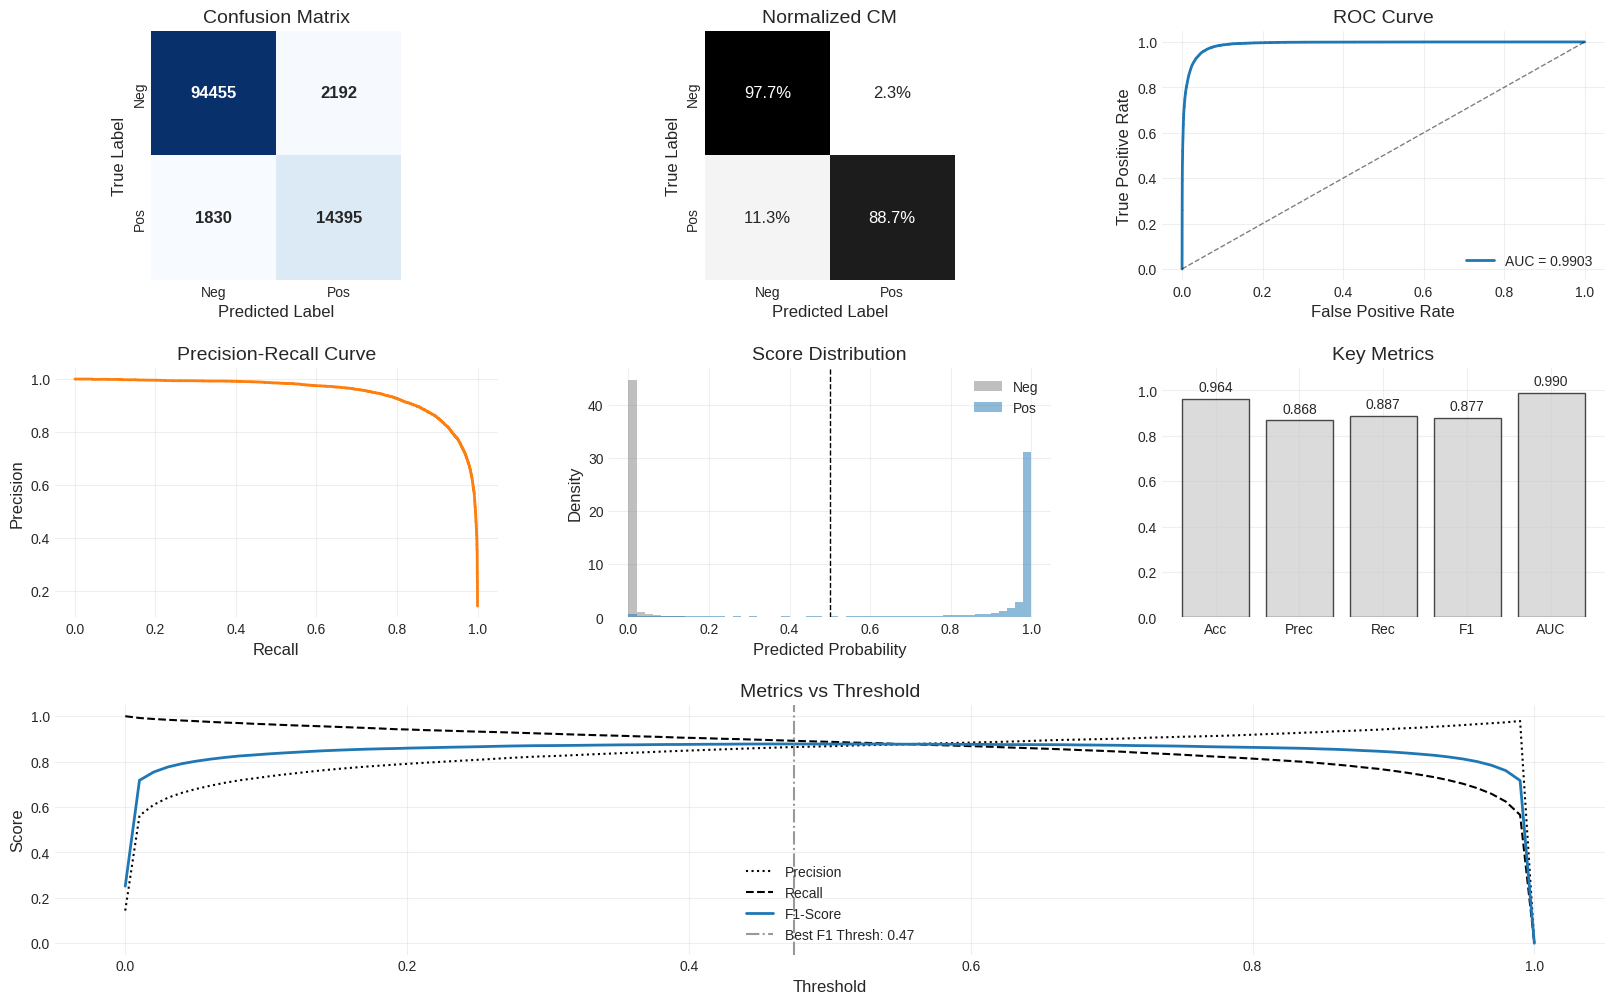

✓ Clean test evaluation plot saved.

EVALUATION COMPLETE!


In [15]:
# ============================================================
# CELL 6: FINAL TEST EVALUATION (Thay thế cell test cũ)
# ============================================================
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60 + "\n")

# Load best model
checkpoint = torch.load("fusion_transformer_best.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from Epoch {checkpoint['epoch']+1}")

# Get detailed predictions
test_loss, test_metrics, test_preds, test_labels = validate(model, test_loader, return_detailed=True)

# Binary predictions
test_preds_binary = (test_preds > 0.5).astype(int)

# Print detailed results
print("\n" + "="*60)
print("FINAL TEST RESULTS")
print("="*60)
print(f"\nOverall Metrics:")
print(f"  Loss      : {test_loss:.4f}")
print(f"  AUC Score : {test_metrics['auc']:.4f}")
print(f"  Accuracy  : {test_metrics['accuracy']:.4f}")
print(f"  Precision : {test_metrics['precision']:.4f}")
print(f"  Recall    : {test_metrics['recall']:.4f}")
print(f"  F1-Score  : {test_metrics['f1']:.4f}")

# Confusion Matrix Details
cm = confusion_matrix(test_labels, test_preds_binary)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"  True Negatives  (TN): {tn:,}")
print(f"  False Positives (FP): {fp:,}")
print(f"  False Negatives (FN): {fn:,}")
print(f"  True Positives  (TP): {tp:,}")

print(f"\nDerived Metrics:")
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
print(f"  Specificity (TNR): {specificity:.4f}")
print(f"  NPV              : {npv:.4f}")

# Classification Report
print("\n" + "-"*60)
print("Detailed Classification Report:")
print("-"*60)
print(classification_report(test_labels, test_preds_binary, 
                          target_names=['Negative', 'Positive'],
                          digits=4))

# Plot comprehensive evaluation
print("\n" + "-"*60)
print("Generating Evaluation Plots...")
print("-"*60 + "\n")
plot_test_evaluation(test_labels, test_preds, test_preds_binary)

print("\n" + "="*60)
print("EVALUATION COMPLETE!")
print("="*60)


STUDY-LEVEL EVALUATION (Patient Diagnosis)
Aggregating predictions per study...


Inference:   0%|          | 0/3262 [00:00<?, ?it/s]


📊 STUDY-LEVEL RESULTS:
  AUC Score : 0.9892
  Accuracy  : 0.9543
  Precision : 0.9385
  Recall    : 0.9505 (Sensitivity)
  F1-Score  : 0.9444


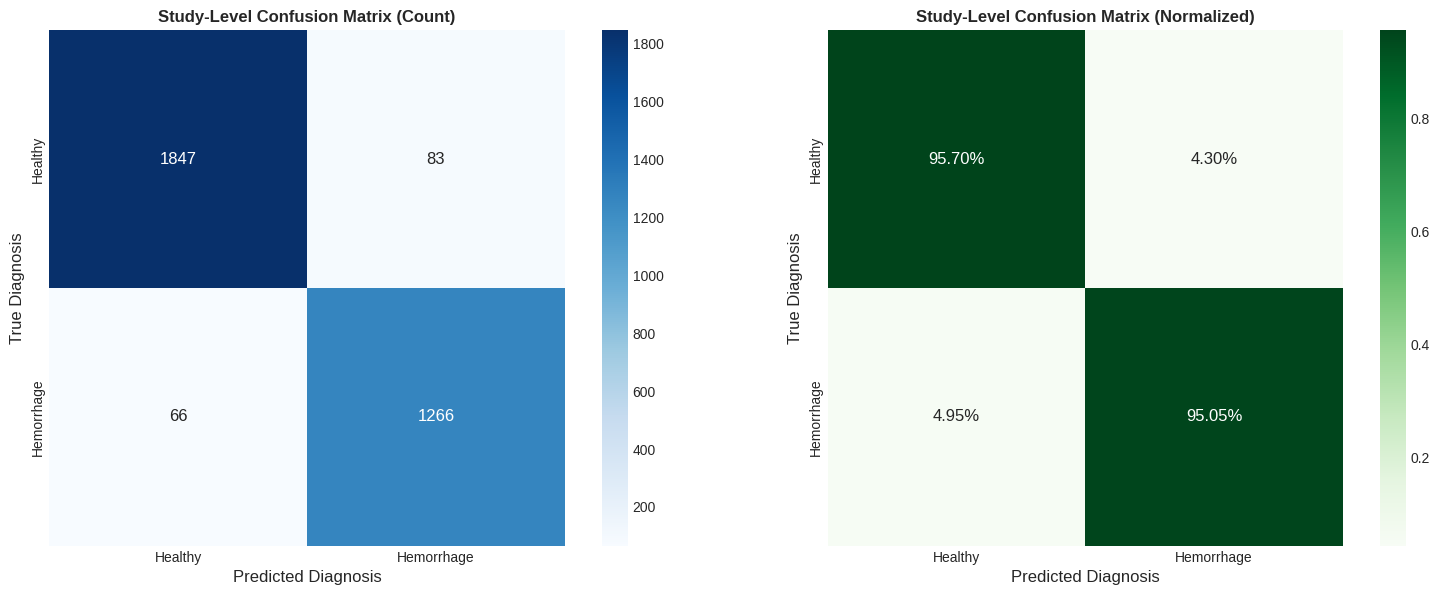

✓ Study-level evaluation plot saved.


In [16]:
# ============================================================\n
# CELL 8: STUDY-LEVEL EVALUATION (PATIENT DIAGNOSIS)
# ============================================================\n
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("\n" + "="*60)
print("STUDY-LEVEL EVALUATION (Patient Diagnosis)")
print("="*60)

# 1. Chạy Inference lại để gom nhóm theo Study
# Lưu ý: Chúng ta dùng trực tiếp test_df vì nó chứa features trọn vẹn của từng study
model.eval()
study_probs = []
study_labels = []
study_ids = []

print("Aggregating predictions per study...")
with torch.no_grad():
    for i, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Inference"):
        # Chuẩn bị input (Thêm batch dimension)
        feats = torch.from_numpy(row['features']).unsqueeze(0).to(cfg.DEVICE) # (1, Seq_Len, 2560)
        
        # Forward Pass
        # Không cần mask vì ta đưa vào từng study một (độ dài thật)
        outputs = model(feats) # (1, Seq_Len, 1)
        
        # Lấy xác suất của từng lát cắt
        slice_probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        
        # LOGIC QUAN TRỌNG: Study Probability = Max(Slice Probabilities)
        # Nếu có bất kỳ lát nào > 0.5 thì coi như bệnh nhân có nguy cơ
        # Hoặc dùng Max Pooling để lấy điểm số tự tin nhất
        study_score = np.max(slice_probs)
        
        study_probs.append(study_score)
        study_labels.append(row['study_label']) # Nhãn thật của Study (0 hoặc 1)
        study_ids.append(row['study_id'])

# Chuyển sang numpy
study_probs = np.array(study_probs)
study_labels = np.array(study_labels)
study_preds = (study_probs > 0.5).astype(int)

# 2. Tính Metrics
study_auc = roc_auc_score(study_labels, study_probs)
study_acc = accuracy_score(study_labels, study_preds)
study_prec = precision_score(study_labels, study_preds, zero_division=0)
study_rec = recall_score(study_labels, study_preds, zero_division=0)
study_f1 = f1_score(study_labels, study_preds, zero_division=0)

print(f"\n📊 STUDY-LEVEL RESULTS:")
print(f"  AUC Score : {study_auc:.4f}")
print(f"  Accuracy  : {study_acc:.4f}")
print(f"  Precision : {study_prec:.4f}")
print(f"  Recall    : {study_rec:.4f} (Sensitivity)")
print(f"  F1-Score  : {study_f1:.4f}")

# 3. Vẽ Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Raw Count Matrix
cm = confusion_matrix(study_labels, study_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], square=True,
            xticklabels=['Healthy', 'Hemorrhage'],
            yticklabels=['Healthy', 'Hemorrhage'])
ax[0].set_title('Study-Level Confusion Matrix (Count)', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Predicted Diagnosis')
ax[0].set_ylabel('True Diagnosis')

# Normalized Matrix (Percentage)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', ax=ax[1], square=True,
            xticklabels=['Healthy', 'Hemorrhage'],
            yticklabels=['Healthy', 'Hemorrhage'])
ax[1].set_title('Study-Level Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Predicted Diagnosis')
ax[1].set_ylabel('True Diagnosis')

plt.tight_layout()
plt.savefig('study_level_evaluation.png', dpi=300)
plt.show()

print("✓ Study-level evaluation plot saved.")